# RNN

In [12]:
import sys
assert sys.version_info >=(3,5)

import sklearn
assert sklearn.__version__>="0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >="0.20"
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

PROJECT_ROOT_DIR ="."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)

def save_fig(fig_id,tight_layout=True,fig_extension="png",resolution=300):
    path = os.path.join(IMAGES_PATH,fig_id +"."+fig_extension)
    print("Saving figure",fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)

# Basic RNN

# Generate the Dataset 


In [5]:
def generate_time_series(batch_size,n_steps):
    freq1,freq2,offsets1,offsets2 = np.random.rand(4,batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time-offsets1) * (freq1 *10  + 10))
    series += 0.2 * np.sin((time-offsets2)*(freq2 *20 +20))
    series += 0.1 *(np.random.rand(batch_size,n_steps) -0.5)
    return series[..., np.newaxis].astype(np.float32)

In [10]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000,n_steps+1)
X_train, y_train = series[:7000, :n_steps],series[:7000,-1]
X_valid, y_valid =series[7000:9000,:n_steps],series[7000:9000,-1]
X_test ,y_test = series[9000:,:n_steps], series[9000:,-1]

In [8]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


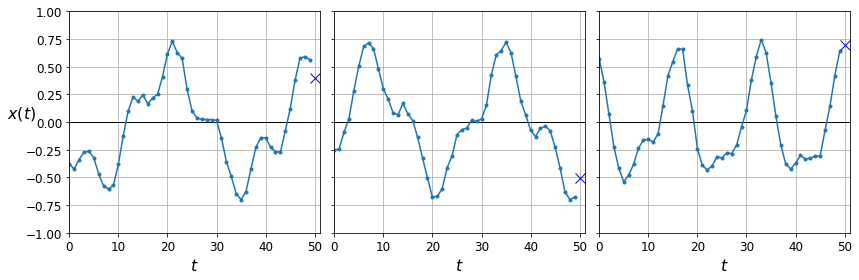

In [13]:
def plot_series(series,y=None,y_pred=None,x_label="$t$",y_label="$x(t)$"):
    plt.plot(series,".-")
    if y is not None:
        plt.plot(n_steps,y,"bx",markersize=10)
    if y_pred is not None:
        plt.plot(n_steps,y_pred,"ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label,fontsize=16)
    if y_label:
        plt.ylabel(y_label,fontsize=16,rotation=0)
    plt.hlines(0,0,100,linewidth=1)
    plt.axis([0,n_steps +1,-1,1])
    
    
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col,:,0],y_valid[col,0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

# Computing Some Baselines

Naive Predictions just predict the last observed values

In [14]:
y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid,y_pred))

0.020211367

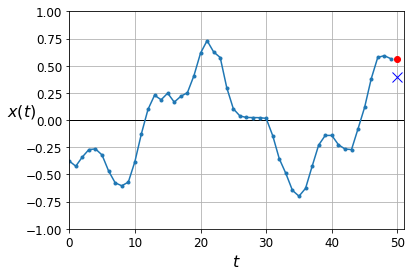

In [15]:
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

Linear Predictions:

In [16]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=20,
                   validation_data=(X_valid,y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 307us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/20
7000/7000 [==============================] - 0s 42us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/20
7000/7000 [==============================] - 0s 41us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 0s 41us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/20
7000/7000 [==============================] - 0s 45us/sample - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
7000/7000 [==============================] - 0s 38us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 40us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 41us/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 0s 42us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 

In [17]:
model.evaluate(X_valid,y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.004112337227910757

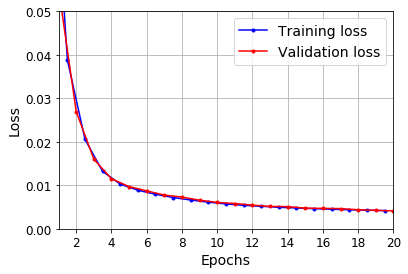

In [18]:
def plot_learning_curves(loss,val_loss):
    plt.plot(np.arange(len(loss)) +0.5,loss,"b.-",label="Training loss")
    plt.plot(np.arange(len(val_loss))+1,val_loss,"r.-",label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1,20,0,0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

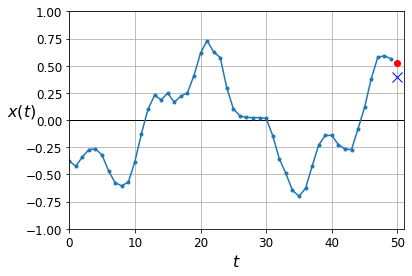

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

# Using a Somple RNN

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1,input_shape=[None,1])
])
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse",optimizer=optimizer)
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 610us/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/20
7000/7000 [==============================] - 3s 476us/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/20
7000/7000 [==============================] - 3s 474us/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/20
7000/7000 [==============================] - 3s 474us/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/20
7000/7000 [==============================] - 3s 475us/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
7000/7000 [==============================] - 3s 478us/sample - loss: 0.0146 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 3s 473us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 3s 474us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 3s 483us/sample - loss: 0.0119 - val_loss: 0.011

In [21]:
model.evaluate(X_valid,y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.010903828606009483

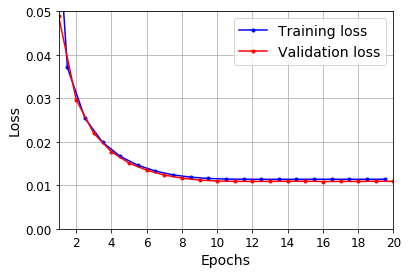

In [22]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

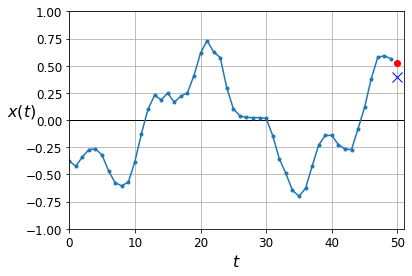

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

# Deep RNNs

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(loss="mse",optimizer="adam")
history= model.fit(X_train,y_train,epochs=20,
                  validation_data=(X_valid,y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0044 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 10/20
70

In [25]:
model.evaluate(X_valid,y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.003111327612772584

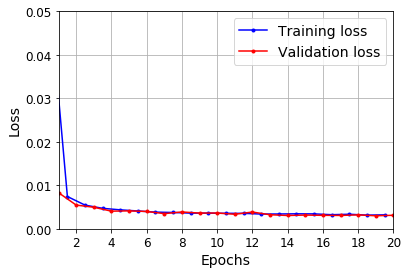

In [26]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])

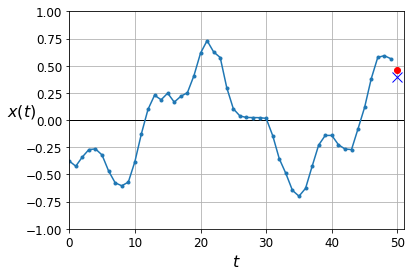

In [28]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

Make the Second SimpleRNNlayer return only last output

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=20,
                   validation_data=(X_valid,y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0240 - val_loss: 0.0050
Epoch 2/20
7000/7000 [==============================] - 6s 882us/sample - loss: 0.0043 - val_loss: 0.0035
Epoch 3/20
7000/7000 [==============================] - 7s 956us/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
7000/7000 [==============================] - 7s 957us/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 6s 886us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 6s 896us/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
7000/7000 [==============================] - 6s 883us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 6s 892us/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 7s 936us/sample - loss: 0.0030 - val_loss: 0.0031


In [30]:
model.evaluate(X_valid,y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0028335092086344956

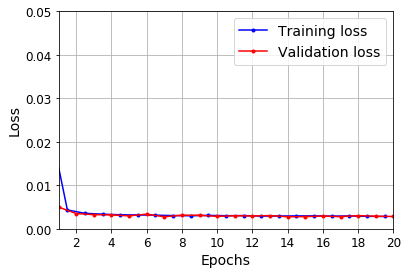

In [31]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])

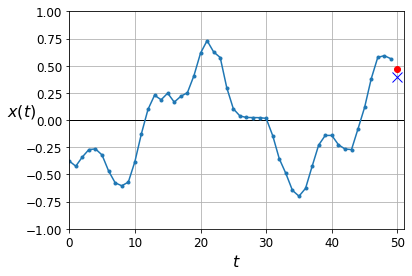

In [32]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

# Forecasting Several Steps Ahead

In [33]:
np.random.seed(43) # not 42 it would give the first series in the train set
series = generate_time_series(1,n_steps +10)
X_new, Y_new = series[:, :n_steps],series[:,n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:,step_ahead:])[:,np.newaxis,:]
    X = np.concatenate([X,y_pred_one],axis=1)
    
Y_pred = X[:,n_steps:]

In [34]:
Y_pred.shape

(1, 10, 1)

Saving figure plot_multiple_forecasts


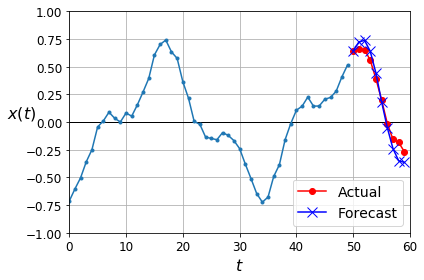

In [35]:
def plot_multiple_forecasts(X,Y,Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0,:,0])
    plt.plot(np.arange(n_steps,n_steps + ahead),Y[0,:,0],"ro-",label="Actual")
    plt.plot(np.arange(n_steps,n_steps + ahead),Y_pred[0,:,0],"bx-",label="Forecast",markersize=10)
    plt.axis([0,n_steps + ahead,-1,1])
    plt.legend(fontsize=14)
    
plot_multiple_forecasts(X_new,Y_new,Y_pred)
save_fig("plot_multiple_forecasts")

Now lets use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more steps

In [36]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000,n_steps+10)
X_train,Y_train = series[:7000, :n_steps],series[:7000,-10:,0]
X_valid,y_valid = series[7000:9000,:n_steps],series[7000:9000,-10:,0]
X_test,y_test =   series[9000:,:n_steps],series[9000:,-10:,0]

Now lets predicts next 10 values one by one 

In [37]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:,np.newaxis,:]
    X = np.concatenate([X,y_pred_one],axis=1)
    
Y_pred = X[:,n_steps:,0]

In [38]:
Y_pred.shape

(2000, 10)

In [40]:
np.mean(keras.metrics.mean_squared_error(y_valid,Y_pred))

0.025828136

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [42]:
Y_naive_pred  =y_valid[:,-1:]
np.mean(keras.metrics.mean_squared_error(y_valid,Y_naive_pred))

0.22278848

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 109us/sample - loss: 0.1335 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 0s 52us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.0385 - val_loss: 0.0354
Epoch 4/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - ETA: 0s - loss: 0.029 - 0s 50us/sample - loss: 0.0298 - val_loss: 0.0282
Epoch 6/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 49us/sample - loss: 0.0257 - val_loss: 0.0249
Epoch 8/20
7000/7000 [==============================] - 0s 50us/sample - loss: 0.0244 - val_loss: 0.0240
Epoch 9/20
7000/7000 [==============================] - 0s 53us/sample - loss: 0.0235 -

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 6s 901us/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 6s 927us/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 6s 899us/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 6s 920us/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 6s 902us/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 6s 896us/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 7s 952us/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 7s 955us/sample - loss: 0.0110 - val_loss: 0.0116


In [51]:
np.random.seed(43)
series = generate_time_series(1,50+10)
X_new, Y_new = series[:,:50,:],series[:,-10:,:]
y_pred = model.predict(X_new)[...,np.newaxis]

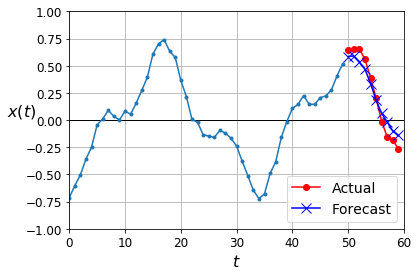

In [52]:
plot_multiple_forecasts(X_new,Y_new,y_pred)

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [53]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000,n_steps+10)
X_train = series[:7000,:n_steps]
X_valid = series[7000:9000,:n_steps]
X_test = series[9000:,:n_steps]
Y = np.empty((10000,n_steps,10))
for step_ahead in range(1,10+1):
    Y[...,step_ahead -1] =series[...,step_ahead:step_ahead + n_steps,0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [54]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [59]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0502 - last_time_step_mse: 0.0392 - val_loss: 0.0422 - val_last_time_step_mse: 0.0309
Epoch 2/20
7000/7000 [==============================] - 6s 916us/sample - loss: 0.0403 - last_time_step_mse: 0.0293 - val_loss: 0.0361 - val_last_time_step_mse: 0.0274
Epoch 3/20
7000/7000 [==============================] - 7s 942us/sample - loss: 0.0409 - last_time_step_mse: 0.0343 - val_loss: 0.0396 - val_last_time_step_mse: 0.0327
Epoch 4/20
7000/7000 [==============================] - 6s 908us/sample - loss: 0.0335 - last_time_step_mse: 0.0239 - val_loss: 0.0285 - val_last_time_step_mse: 0.0174
Epoch 5/20
7000/7000 [==============================] - 6s 927us/sample - loss: 0.0286 - last_time_step_mse: 0.0175 - val_loss: 0.0263 - val_last_time_step_mse: 0.0151
Epoch 6/20
7000/7000 [==============================] - 6s 917us/sample - loss: 0.0247 - last_time_step_mse: 0.012

In [60]:
np.random.seed(43)

series = generate_time_series(1,50 +10)
X_new , y_new = series[:,:50,:],series[:,50:,:]
Y_pred = model.predict(X_new)[:,-1][...,np.newaxis]


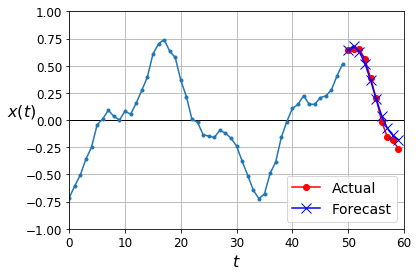

In [61]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)

# Deep RNN with Batch Norm 

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1935 - last_time_step_mse: 0.1917 - val_loss: 0.0902 - val_last_time_step_mse: 0.0864
Epoch 2/20
7000/7000 [==============================] - 6s 910us/sample - loss: 0.0535 - last_time_step_mse: 0.0447 - val_loss: 0.0556 - val_last_time_step_mse: 0.0468
Epoch 3/20
7000/7000 [==============================] - 7s 947us/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0357
Epoch 4/20
7000/7000 [==============================] - 7s 954us/sample - loss: 0.0436 - last_time_step_mse: 0.0335 - val_loss: 0.0417 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 7s 964us/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0405 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 6s 925us/sample - loss: 0.0385 - last_time_step_mse: 0.027

# Deep RNNs With Layer Norm

In [66]:
from tensorflow.keras.layers import LayerNormalization

In [71]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self,units,activation='tanh',**kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self,inputs=None,batch_size=None,dtype=None):
        if inputs is  not None:
            batch_size =tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size,self.state_size],dtype=dtype)]
    def call(self,inputs,states):
        outputs, new_states = self.simple_rnn_cell(inputs,states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [72]:
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20),return_sequences=True,input_shape=[None,1]),
    keras.layers.RNN(LNSimpleRNNCell(20),return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.1607 - last_time_step_mse: 0.1606 - val_loss: 0.0726 - val_last_time_step_mse: 0.0649
Epoch 2/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0638 - last_time_step_mse: 0.0524 - val_loss: 0.0582 - val_last_time_step_mse: 0.0453
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0553 - last_time_step_mse: 0.0430 - val_loss: 0.0523 - val_last_time_step_mse: 0.0396
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0497 - last_time_step_mse: 0.0384 - val_loss: 0.0469 - val_last_time_step_mse: 0.0356
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0453 - last_time_step_mse: 0.0343 - val_loss: 0.0428 - val_last_time_step_mse: 0.0311
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0414 - last_time_step_mse: 0.0305 - 

# Creating a Custom RNN Class

In [74]:
class MyRNN(keras.layers.Layer):
    def __init__(self,cell,return_sequences=False,**kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell,"get_initial_state",self.fallback_initial_state)
    def fallback_initial_state(self,inputs):
        return [tf.zeros([self.cell.state_size],dtype=inputs.dtype)]
    @tf.function
    def call(self,inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype,size=n_steps)
        outputs = tf.zeros(shape=[n_steps,self.cell.output_size],dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs,states = self.cell(inputs[:,step],states)
            if self.return_sequences:
                sequences = sequences.write(step,outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [76]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20),return_sequences=True,
         input_shape=[None,1]),
    MyRNN(LNSimpleRNNCell(20),return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history =  model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.2176 - last_time_step_mse: 0.2049 - val_loss: 0.0845 - val_last_time_step_mse: 0.0724
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0716 - last_time_step_mse: 0.0608 - val_loss: 0.0630 - val_last_time_step_mse: 0.0514
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0584 - last_time_step_mse: 0.0456 - val_loss: 0.0546 - val_last_time_step_mse: 0.0405
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0519 - last_time_step_mse: 0.0385 - val_loss: 0.0497 - val_last_time_step_mse: 0.0358
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0477 - last_time_step_mse: 0.0341 - val_loss: 0.0459 - val_last_time_step_mse: 0.0317
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0445 - last_time_step_mse: 0.0307 - va

# LSTM

In [77]:
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0766 - last_time_step_mse: 0.0628 - val_loss: 0.0555 - val_last_time_step_mse: 0.0371
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0426 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0391 - last_time_step_mse: 0.0186 - val_loss: 0.0375 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0352 - last_time_step_mse: 0.0154 - val_loss: 0.0334 - val_last_time_step_mse: 0.0133
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0327 - last_time_step_mse: 0.0134 - val_loss: 0.0316 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0311 - last_time_step_mse: 0.0125 - val_l

In [78]:
model.evaluate(X_valid,Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.023756912380456924, 0.008638697]

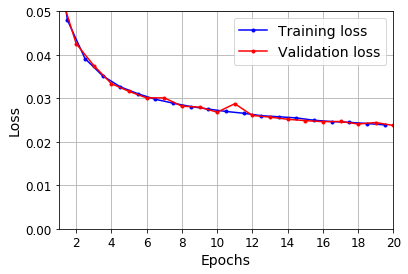

In [79]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

In [82]:
np.random.seed(43)
series = generate_time_series(1,50+10)
X_new, Y_new = series[:,:50,:],series[:,50:,:]
Y_pred = model.predict(X_new)[:,-1][...,np.newaxis]

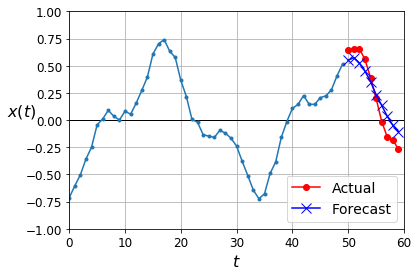

In [83]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)

# GRU

In [84]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs=20,
                   validation_data=(X_valid,Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0745 - last_time_step_mse: 0.0668 - val_loss: 0.0526 - val_last_time_step_mse: 0.0413
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0478 - last_time_step_mse: 0.0369 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0395 - val_last_time_step_mse: 0.0275
Epoch 4/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0375 - last_time_step_mse: 0.0250 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0327 - last_time_step_mse: 0.0178 - val_loss: 0.0311 - val_last_time_step_mse: 0.0156
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0309 - last_time_step_mse: 0.0157 - 

In [85]:
model.evaluate(X_valid,Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.024027103409171104, 0.010358049]

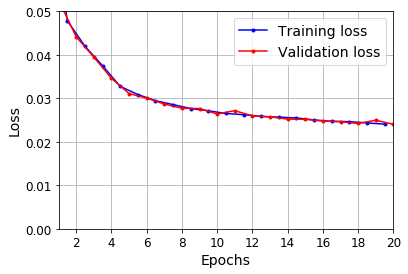

In [86]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])


In [87]:
np.random.seed(43)

series = generate_time_series(1,50+10)
X_new , Y_new = series[:,:50,:],series[:,50:,:]
Y_pred = model.predict(X_new)[:,-1][...,np.newaxis]

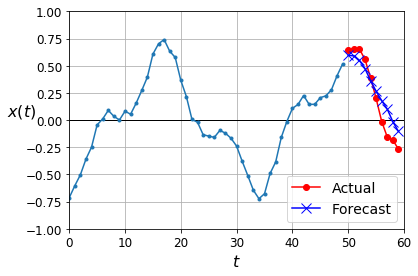

In [89]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)

# Using One-Dimensional Convolutional Layers to Process Sequences¶
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59

In [92]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20,kernel_size=4,strides=2,padding="valid",
                       input_shape=[None,1]),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))


Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0686 - last_time_step_mse: 0.0609 - val_loss: 0.0485 - val_last_time_step_mse: 0.0406
Epoch 2/20
7000/7000 [==============================] - 6s 889us/sample - loss: 0.0420 - last_time_step_mse: 0.0346 - val_loss: 0.0370 - val_last_time_step_mse: 0.0290
Epoch 3/20
7000/7000 [==============================] - 6s 865us/sample - loss: 0.0341 - last_time_step_mse: 0.0262 - val_loss: 0.0307 - val_last_time_step_mse: 0.0215
Epoch 4/20
7000/7000 [==============================] - 6s 849us/sample - loss: 0.0282 - last_time_step_mse: 0.0183 - val_loss: 0.0258 - val_last_time_step_mse: 0.0149
Epoch 5/20
7000/7000 [==============================] - 6s 831us/sample - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0239 - val_last_time_step_mse: 0.0130
Epoch 6/20
7000/7000 [==============================] - 6s 842us/sample - loss: 0.0236 - last_time_step_mse: 0.01

# WaveNet

X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

In [93]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 916us/sample - loss: 0.0668 - last_time_step_mse: 0.0541 - val_loss: 0.0361 - val_last_time_step_mse: 0.0225
Epoch 2/20
7000/7000 [==============================] - 4s 503us/sample - loss: 0.0320 - last_time_step_mse: 0.0195 - val_loss: 0.0308 - val_last_time_step_mse: 0.0193
Epoch 3/20
7000/7000 [==============================] - 4s 515us/sample - loss: 0.0279 - last_time_step_mse: 0.0159 - val_loss: 0.0269 - val_last_time_step_mse: 0.0147
Epoch 4/20
7000/7000 [==============================] - 4s 516us/sample - loss: 0.0258 - last_time_step_mse: 0.0139 - val_loss: 0.0248 - val_last_time_step_mse: 0.0126
Epoch 5/20
7000/7000 [==============================] - 4s 513us/sample - loss: 0.0248 - last_time_step_mse: 0.0131 - val_loss: 0.0242 - val_last_time_step_mse: 0.0122
Epoch 6/20
7000/7000 [==============================] - 4s 507us/sample - loss: 0.0240 - last_time_step_mse: 0.0

In [95]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self,activation="tanh",**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self,inputs):
        n_filters = inputs.shape[-1]//2
        linear_output = self.activation(inputs[...,:n_filters])
        gate = keras.activations.sigmoid(inputs[...,n_filters:])
        return self.activation(linear_output) * gate

In [96]:
def wavenetresidual_block(inputs,n_filters,dilation_rate):
    z = keras.layers.Conv1D(2 *n_filters,kernel_size=2,padding="causal",
                           dilation_rate = dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters,kernel_size=1)(z)
    return keras.layers.Add()([z,inputs]),z

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
n_layers_per_block =3
n_blocks =1
n_filters = 32
n_outputs = 10


inputs = keras.layers.Input(shape=[None,1])
z = keras.layers.Conv1D(n_filters,kernel_size=2,padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenetresidual_block(z,n_filters,dilation_rate)
    skip_to_last.append(skip)
    
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters,kernel_size=1,activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs,kernel_size=1,activation="softmax")(z)
model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [101]:
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.1284 - last_time_step_mse: 0.1241 - val_loss: 0.1225 - val_last_time_step_mse: 0.1195
Epoch 2/2
7000/7000 [==============================] - 5s 686us/sample - loss: 0.1220 - last_time_step_mse: 0.1176 - val_loss: 0.1217 - val_last_time_step_mse: 0.1188


# Embedded Reber Grammars


First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [102]:
np.random.seed(42)

In [103]:
default_reber_grammar=[
     [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]] 
embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output= []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production,list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)


Let's generate a few strings based on the default Reber grammar:

In [105]:
for _ in range(25):
    print(generate_string(default_reber_grammar),end=" ")

BTXSE BPTTTTTTTTTVPSE BPVPXTTVPXTTTVPSE BTXXTVVE BPTVPXVVE BTSXSE BPTTTTTTVPXTVPXVPXTTTVVE BPTTTVPXVPSE BPVPXTTTTTVPSE BTSSXSE BPVPSE BTSXSE BPVVE BPVVE BTXSE BTXXTVPXTTVPSE BTSSSXSE BTSXXTTVVE BPTTVVE BPVPSE BTXXVVE BPVPSE BTSSSXXTTVVE BPVPXVPXTVVE BTXSE 

In [106]:

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BPBPVPSEPE BTBTXXTTVVETE BTBPVVETE BPBTSXSEPE BTBTXXVVETE BTBTXSETE BTBPTVPXTVVETE BTBPTTVVETE BTBPVPXVPXVPXVVETE BTBTXSETE BPBPTVVEPE BTBPTVVETE BPBTSXXTTTTTVVEPE BTBPVVETE BPBTXSEPE BTBTXSETE BPBPVVEPE BTBPVPXTTVVETE BPBPVVEPE BTBPTTVPSETE BTBPTVVETE BPBPVPXTVPSEPE BPBTSXXVVEPE BPBPVPXVVEPE BTBTXXVPSETE 

In [107]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

In [108]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTPTTVPSETE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS BXBTXSETE BTBTXXVPSPTE BPBTXXEPE BTBPTTVPSETT BTBXXSETE BSBTSXSETE BPBPTTEPXVVEPE PTBPTVPXTVPXVVETE BPBPVVEPV BTBTXXTVPXVPXTVPETE BTBPBTVVETE BPBPSVEPE BPBPSVEPE BTBPVVXVVETE BPBPVPSEPS BPBPTVPEVVEPE 